In [1]:
#---This program is used to forecast 1 week CDRs based on 55 previous days' data

#---Install these bibs so the program works properly
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from numpy import loadtxt
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
#--Loading Cell_ID vector, whose elements tell from which ID the matrix_TS row is the corresponding time-series

Cell_ID = loadtxt('ID_labels.csv', delimiter=',') 
df = pd.read_csv('matrixTS.csv',header=None)
df.head(6)

,0,1,2,3,4,5,6,7,8,9,...,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487
0,13,11,8,7,8,9,11,12,13,18,...,23.0,17.0,20.0,16.0,16.0,18.0,19.0,21.0,17.0,13.0
1,13,11,10,7,6,9,11,11,13,17,...,22.0,15.0,20.0,15.0,15.0,18.0,20.0,19.0,17.0,13.0
2,15,11,9,11,9,8,12,18,23,31,...,6.0,9.0,9.0,11.0,8.0,7.0,7.0,8.0,7.0,5.0
3,12,11,7,9,6,6,8,15,12,23,...,14.0,12.0,17.0,17.0,15.0,14.0,12.0,13.0,14.0,10.0
4,10,8,11,7,8,8,12,16,16,16,...,28.0,26.0,23.0,26.0,27.0,19.0,18.0,20.0,14.0,18.0
5,11,8,7,6,8,8,6,7,12,14,...,14.0,13.0,12.0,14.0,14.0,12.0,12.0,16.0,11.0,10.0


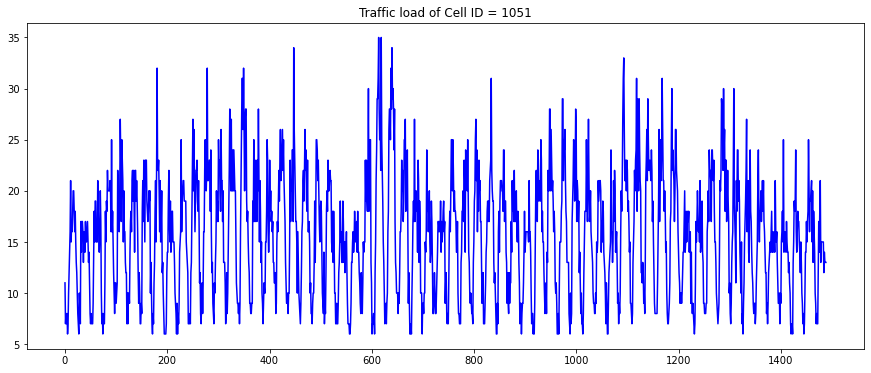

In [3]:
#--Defines the Cell ID to be forecasted and plots the corresponding time-series

days = 62 #Train and validation size need to be changed if this value is tunned
matrix = df.to_numpy()

ID=60
time_series = matrix[ID][:]
hour = np.linspace(0,24*days,24*days)

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell ID = %d' % (Cell_ID[60])) 
plt.plot(hour,time_series,'b')

In [4]:
#---This function creates the sliding window to construct the training data set

def df_to_X_y(df,window_size):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        y.append(df_as_np[i+window_size])
    return np.array(X), np.array(y)

#-Each vector of matrix X contains "window_size" elements used as input to train the model
#-Each element of vector y contains one element that the model needs to predict based on the respective row of X

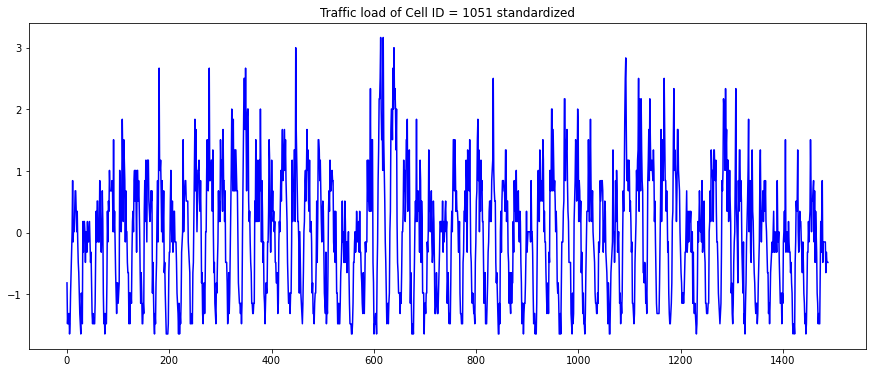

In [5]:
#---Standardization of the CDR time-series

train_size = 24*50 # defines number of samples of training data: 50 days with 24 samples each
validation_size = 24*5 # defines number of samples of validation data: 5 days with 24 samples each

time_series_mean = time_series[:train_size].mean() #--Considering just the training part
time_series_std = time_series[:train_size].std() #--Considering just the training part

time_series_standardized = (time_series - time_series_mean) / time_series_std

plt.figure(figsize=(15,6))
plt.title('Traffic load of Cell ID = %d standardized' % (Cell_ID[60])) 
plt.plot(hour,time_series_standardized,'b')

In [6]:
WINDOW_SIZE = 24
X,y = df_to_X_y(time_series_standardized,WINDOW_SIZE)
X.shape, y.shape

((1464, 24, 1), (1464,))

## Splitting data to training and testing

In [7]:

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:(train_size+validation_size)], y[train_size:(train_size+validation_size)]
y_test = time_series[(train_size+validation_size):]

X_train.shape, X_val.shape

((1200, 24, 1), (120, 24, 1))

## Constructing GRU model

In [8]:
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE,1)))

#-Comment or uncomment lines to insert/remove layers of the GRU
#-Change the number of neurons inside each layers

#model1.add(GRU(32,return_sequences=True)) # default activation function is tanh
#model1.add(GRU(32,return_sequences=True)) # default activation function is tanh
model1.add(GRU(64,return_sequences=True)) # default activation function is tanh
model1.add(GRU(64)) # default activation function is tanh

model1.add(Dense(32,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24, 64)            12864     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 39,937
Trainable params: 39,937
Non-trainable params: 0
_________________________________________________________________


In [9]:
#---Model Training


#-Set the hyperparemeters according to your application: learning_rate, epochs, batch size
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.fit(X_train,y_train, validation_data=(X_val,y_val),epochs=1000, batch_size=32)

Train on 1200 samples, validate on 120 samples
Epoch 1/1000
1200/1200 [==============================] - 3s 3ms/sample - loss: 0.8120 - root_mean_squared_error: 0.9011 - val_loss: 0.7336 - val_root_mean_squared_error: 0.8565
Epoch 2/1000
1200/1200 [==============================] - 1s 580us/sample - loss: 0.6538 - root_mean_squared_error: 0.8086 - val_loss: 0.6199 - val_root_mean_squared_error: 0.7873
Epoch 3/1000
1200/1200 [==============================] - 1s 580us/sample - loss: 0.5295 - root_mean_squared_error: 0.7277 - val_loss: 0.5175 - val_root_mean_squared_error: 0.7194
Epoch 4/1000
1200/1200 [==============================] - 1s 568us/sample - loss: 0.4078 - root_mean_squared_error: 0.6386 - val_loss: 0.4256 - val_root_mean_squared_error: 0.6524
Epoch 5/1000
1200/1200 [==============================] - 1s 576us/sample - loss: 0.3153 - root_mean_squared_error: 0.5615 - val_loss: 0.3814 - val_root_mean_squared_error: 0.6176
Epoch 6/1000
1200/1200 [==============================]

1200/1200 [==============================] - 1s 589us/sample - loss: 0.2268 - root_mean_squared_error: 0.4762 - val_loss: 0.2922 - val_root_mean_squared_error: 0.5405
Epoch 47/1000
1200/1200 [==============================] - 1s 575us/sample - loss: 0.2263 - root_mean_squared_error: 0.4757 - val_loss: 0.2830 - val_root_mean_squared_error: 0.5320
Epoch 48/1000
1200/1200 [==============================] - 1s 589us/sample - loss: 0.2256 - root_mean_squared_error: 0.4750 - val_loss: 0.2891 - val_root_mean_squared_error: 0.5377
Epoch 49/1000
1200/1200 [==============================] - 1s 590us/sample - loss: 0.2243 - root_mean_squared_error: 0.4736 - val_loss: 0.2867 - val_root_mean_squared_error: 0.5354
Epoch 50/1000
1200/1200 [==============================] - 1s 583us/sample - loss: 0.2247 - root_mean_squared_error: 0.4740 - val_loss: 0.2826 - val_root_mean_squared_error: 0.5316
Epoch 51/1000
1200/1200 [==============================] - 1s 593us/sample - loss: 0.2244 - root_mean_squared

1200/1200 [==============================] - 1s 584us/sample - loss: 0.2128 - root_mean_squared_error: 0.4613 - val_loss: 0.2837 - val_root_mean_squared_error: 0.5327
Epoch 92/1000
1200/1200 [==============================] - 1s 584us/sample - loss: 0.2147 - root_mean_squared_error: 0.4633 - val_loss: 0.2873 - val_root_mean_squared_error: 0.5360
Epoch 93/1000
1200/1200 [==============================] - 1s 583us/sample - loss: 0.2126 - root_mean_squared_error: 0.4610 - val_loss: 0.2893 - val_root_mean_squared_error: 0.5378
Epoch 94/1000
1200/1200 [==============================] - 1s 577us/sample - loss: 0.2165 - root_mean_squared_error: 0.4653 - val_loss: 0.2920 - val_root_mean_squared_error: 0.5403
Epoch 95/1000
1200/1200 [==============================] - 1s 593us/sample - loss: 0.2135 - root_mean_squared_error: 0.4621 - val_loss: 0.2937 - val_root_mean_squared_error: 0.5419
Epoch 96/1000
1200/1200 [==============================] - 1s 580us/sample - loss: 0.2139 - root_mean_squared

1200/1200 [==============================] - 1s 601us/sample - loss: 0.2093 - root_mean_squared_error: 0.4575 - val_loss: 0.2988 - val_root_mean_squared_error: 0.5466
Epoch 137/1000
1200/1200 [==============================] - 1s 622us/sample - loss: 0.2089 - root_mean_squared_error: 0.4570 - val_loss: 0.2940 - val_root_mean_squared_error: 0.5422
Epoch 138/1000
1200/1200 [==============================] - 1s 605us/sample - loss: 0.2077 - root_mean_squared_error: 0.4558 - val_loss: 0.2991 - val_root_mean_squared_error: 0.5469
Epoch 139/1000
1200/1200 [==============================] - 1s 659us/sample - loss: 0.2104 - root_mean_squared_error: 0.4587 - val_loss: 0.2973 - val_root_mean_squared_error: 0.5453
Epoch 140/1000
1200/1200 [==============================] - 1s 593us/sample - loss: 0.2096 - root_mean_squared_error: 0.4578 - val_loss: 0.2906 - val_root_mean_squared_error: 0.5391
Epoch 141/1000
1200/1200 [==============================] - 1s 618us/sample - loss: 0.2108 - root_mean_sq

1200/1200 [==============================] - 1s 573us/sample - loss: 0.2072 - root_mean_squared_error: 0.4552 - val_loss: 0.2938 - val_root_mean_squared_error: 0.5420
Epoch 182/1000
1200/1200 [==============================] - 1s 582us/sample - loss: 0.2058 - root_mean_squared_error: 0.4536 - val_loss: 0.2926 - val_root_mean_squared_error: 0.5409
Epoch 183/1000
1200/1200 [==============================] - 1s 583us/sample - loss: 0.2064 - root_mean_squared_error: 0.4543 - val_loss: 0.2941 - val_root_mean_squared_error: 0.5423
Epoch 184/1000
1200/1200 [==============================] - 1s 564us/sample - loss: 0.2064 - root_mean_squared_error: 0.4543 - val_loss: 0.2907 - val_root_mean_squared_error: 0.5392
Epoch 185/1000
1200/1200 [==============================] - 1s 578us/sample - loss: 0.2065 - root_mean_squared_error: 0.4545 - val_loss: 0.2910 - val_root_mean_squared_error: 0.5394
Epoch 186/1000
1200/1200 [==============================] - 1s 578us/sample - loss: 0.2070 - root_mean_sq

1200/1200 [==============================] - 1s 566us/sample - loss: 0.2048 - root_mean_squared_error: 0.4525 - val_loss: 0.2920 - val_root_mean_squared_error: 0.5404
Epoch 227/1000
1200/1200 [==============================] - 1s 563us/sample - loss: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 0.2977 - val_root_mean_squared_error: 0.5456
Epoch 228/1000
1200/1200 [==============================] - 1s 572us/sample - loss: 0.2044 - root_mean_squared_error: 0.4521 - val_loss: 0.2940 - val_root_mean_squared_error: 0.5422
Epoch 229/1000
1200/1200 [==============================] - 1s 569us/sample - loss: 0.2045 - root_mean_squared_error: 0.4522 - val_loss: 0.2919 - val_root_mean_squared_error: 0.5403
Epoch 230/1000
1200/1200 [==============================] - 1s 570us/sample - loss: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 0.2946 - val_root_mean_squared_error: 0.5428
Epoch 231/1000
1200/1200 [==============================] - 1s 575us/sample - loss: 0.2050 - root_mean_sq

1200/1200 [==============================] - 1s 587us/sample - loss: 0.2032 - root_mean_squared_error: 0.4507 - val_loss: 0.2983 - val_root_mean_squared_error: 0.5461
Epoch 272/1000
1200/1200 [==============================] - 1s 582us/sample - loss: 0.2030 - root_mean_squared_error: 0.4505 - val_loss: 0.2942 - val_root_mean_squared_error: 0.5424
Epoch 273/1000
1200/1200 [==============================] - 1s 603us/sample - loss: 0.2035 - root_mean_squared_error: 0.4511 - val_loss: 0.2971 - val_root_mean_squared_error: 0.5451
Epoch 274/1000
1200/1200 [==============================] - 1s 574us/sample - loss: 0.2029 - root_mean_squared_error: 0.4504 - val_loss: 0.3000 - val_root_mean_squared_error: 0.5477
Epoch 275/1000
1200/1200 [==============================] - 1s 581us/sample - loss: 0.2027 - root_mean_squared_error: 0.4502 - val_loss: 0.2922 - val_root_mean_squared_error: 0.5406
Epoch 276/1000
1200/1200 [==============================] - 1s 573us/sample - loss: 0.2033 - root_mean_sq

1200/1200 [==============================] - 1s 577us/sample - loss: 0.2012 - root_mean_squared_error: 0.4486 - val_loss: 0.2953 - val_root_mean_squared_error: 0.5434
Epoch 317/1000
1200/1200 [==============================] - 1s 565us/sample - loss: 0.2022 - root_mean_squared_error: 0.4496 - val_loss: 0.2981 - val_root_mean_squared_error: 0.5460
Epoch 318/1000
1200/1200 [==============================] - 1s 564us/sample - loss: 0.2008 - root_mean_squared_error: 0.4481 - val_loss: 0.2949 - val_root_mean_squared_error: 0.5430
Epoch 319/1000
1200/1200 [==============================] - 1s 577us/sample - loss: 0.2021 - root_mean_squared_error: 0.4495 - val_loss: 0.2985 - val_root_mean_squared_error: 0.5464
Epoch 320/1000
1200/1200 [==============================] - 1s 568us/sample - loss: 0.2017 - root_mean_squared_error: 0.4491 - val_loss: 0.2972 - val_root_mean_squared_error: 0.5452
Epoch 321/1000
1200/1200 [==============================] - 1s 567us/sample - loss: 0.2029 - root_mean_sq

1200/1200 [==============================] - 1s 573us/sample - loss: 0.2016 - root_mean_squared_error: 0.4490 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458
Epoch 362/1000
1200/1200 [==============================] - 1s 571us/sample - loss: 0.2010 - root_mean_squared_error: 0.4483 - val_loss: 0.2994 - val_root_mean_squared_error: 0.5472
Epoch 363/1000
1200/1200 [==============================] - 1s 571us/sample - loss: 0.2010 - root_mean_squared_error: 0.4483 - val_loss: 0.2983 - val_root_mean_squared_error: 0.5462
Epoch 364/1000
1200/1200 [==============================] - 1s 566us/sample - loss: 0.1999 - root_mean_squared_error: 0.4471 - val_loss: 0.3002 - val_root_mean_squared_error: 0.5479
Epoch 365/1000
1200/1200 [==============================] - 1s 581us/sample - loss: 0.2014 - root_mean_squared_error: 0.4488 - val_loss: 0.2996 - val_root_mean_squared_error: 0.5473
Epoch 366/1000
1200/1200 [==============================] - 1s 568us/sample - loss: 0.2024 - root_mean_sq

1200/1200 [==============================] - 1s 597us/sample - loss: 0.1985 - root_mean_squared_error: 0.4456 - val_loss: 0.3022 - val_root_mean_squared_error: 0.5497
Epoch 407/1000
1200/1200 [==============================] - 1s 674us/sample - loss: 0.1997 - root_mean_squared_error: 0.4468 - val_loss: 0.2949 - val_root_mean_squared_error: 0.5430
Epoch 408/1000
1200/1200 [==============================] - 1s 611us/sample - loss: 0.1992 - root_mean_squared_error: 0.4463 - val_loss: 0.2966 - val_root_mean_squared_error: 0.5446
Epoch 409/1000
1200/1200 [==============================] - 1s 613us/sample - loss: 0.2013 - root_mean_squared_error: 0.4486 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 410/1000
1200/1200 [==============================] - 1s 602us/sample - loss: 0.1993 - root_mean_squared_error: 0.4465 - val_loss: 0.3003 - val_root_mean_squared_error: 0.5480
Epoch 411/1000
1200/1200 [==============================] - 1s 530us/sample - loss: 0.1997 - root_mean_sq

1200/1200 [==============================] - 2s 1ms/sample - loss: 0.1987 - root_mean_squared_error: 0.4458 - val_loss: 0.2959 - val_root_mean_squared_error: 0.5440
Epoch 452/1000
1200/1200 [==============================] - 1s 919us/sample - loss: 0.1979 - root_mean_squared_error: 0.4448 - val_loss: 0.2959 - val_root_mean_squared_error: 0.5439
Epoch 453/1000
1200/1200 [==============================] - 1s 745us/sample - loss: 0.1975 - root_mean_squared_error: 0.4444 - val_loss: 0.3010 - val_root_mean_squared_error: 0.5487
Epoch 454/1000
1200/1200 [==============================] - 1s 691us/sample - loss: 0.1980 - root_mean_squared_error: 0.4450 - val_loss: 0.2962 - val_root_mean_squared_error: 0.5443
Epoch 455/1000
1200/1200 [==============================] - 1s 756us/sample - loss: 0.1969 - root_mean_squared_error: 0.4437 - val_loss: 0.2993 - val_root_mean_squared_error: 0.5471
Epoch 456/1000
1200/1200 [==============================] - 1s 674us/sample - loss: 0.1969 - root_mean_squa

1200/1200 [==============================] - 1s 529us/sample - loss: 0.1986 - root_mean_squared_error: 0.4456 - val_loss: 0.3017 - val_root_mean_squared_error: 0.5493
Epoch 497/1000
1200/1200 [==============================] - 1s 525us/sample - loss: 0.1974 - root_mean_squared_error: 0.4443 - val_loss: 0.2971 - val_root_mean_squared_error: 0.5451
Epoch 498/1000
1200/1200 [==============================] - 1s 525us/sample - loss: 0.1953 - root_mean_squared_error: 0.4420 - val_loss: 0.3039 - val_root_mean_squared_error: 0.5512
Epoch 499/1000
1200/1200 [==============================] - 1s 505us/sample - loss: 0.1971 - root_mean_squared_error: 0.4439 - val_loss: 0.2987 - val_root_mean_squared_error: 0.5465
Epoch 500/1000
1200/1200 [==============================] - 1s 513us/sample - loss: 0.1959 - root_mean_squared_error: 0.4427 - val_loss: 0.2993 - val_root_mean_squared_error: 0.5471
Epoch 501/1000
1200/1200 [==============================] - 1s 524us/sample - loss: 0.1960 - root_mean_sq

1200/1200 [==============================] - 1s 504us/sample - loss: 0.1947 - root_mean_squared_error: 0.4412 - val_loss: 0.3010 - val_root_mean_squared_error: 0.5487
Epoch 542/1000
1200/1200 [==============================] - 1s 506us/sample - loss: 0.1946 - root_mean_squared_error: 0.4411 - val_loss: 0.3058 - val_root_mean_squared_error: 0.5530
Epoch 543/1000
1200/1200 [==============================] - 1s 509us/sample - loss: 0.1943 - root_mean_squared_error: 0.4407 - val_loss: 0.3042 - val_root_mean_squared_error: 0.5516
Epoch 544/1000
1200/1200 [==============================] - 1s 509us/sample - loss: 0.1950 - root_mean_squared_error: 0.4416 - val_loss: 0.3028 - val_root_mean_squared_error: 0.5503
Epoch 545/1000
1200/1200 [==============================] - 1s 504us/sample - loss: 0.1948 - root_mean_squared_error: 0.4413 - val_loss: 0.3083 - val_root_mean_squared_error: 0.5552
Epoch 546/1000
1200/1200 [==============================] - 1s 514us/sample - loss: 0.1957 - root_mean_sq

1200/1200 [==============================] - 1s 505us/sample - loss: 0.1922 - root_mean_squared_error: 0.4384 - val_loss: 0.3021 - val_root_mean_squared_error: 0.5496
Epoch 587/1000
1200/1200 [==============================] - 1s 496us/sample - loss: 0.1939 - root_mean_squared_error: 0.4404 - val_loss: 0.3045 - val_root_mean_squared_error: 0.5518
Epoch 588/1000
1200/1200 [==============================] - 1s 500us/sample - loss: 0.1917 - root_mean_squared_error: 0.4379 - val_loss: 0.3084 - val_root_mean_squared_error: 0.5554
Epoch 589/1000
1200/1200 [==============================] - 1s 503us/sample - loss: 0.1924 - root_mean_squared_error: 0.4386 - val_loss: 0.3095 - val_root_mean_squared_error: 0.5563
Epoch 590/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1923 - root_mean_squared_error: 0.4386 - val_loss: 0.3030 - val_root_mean_squared_error: 0.5505
Epoch 591/1000
1200/1200 [==============================] - 1s 497us/sample - loss: 0.1929 - root_mean_sq

1200/1200 [==============================] - 1s 504us/sample - loss: 0.1901 - root_mean_squared_error: 0.4360 - val_loss: 0.3030 - val_root_mean_squared_error: 0.5505
Epoch 632/1000
1200/1200 [==============================] - 1s 504us/sample - loss: 0.1900 - root_mean_squared_error: 0.4359 - val_loss: 0.3034 - val_root_mean_squared_error: 0.5508
Epoch 633/1000
1200/1200 [==============================] - 1s 507us/sample - loss: 0.1909 - root_mean_squared_error: 0.4369 - val_loss: 0.3102 - val_root_mean_squared_error: 0.5569
Epoch 634/1000
1200/1200 [==============================] - 1s 501us/sample - loss: 0.1912 - root_mean_squared_error: 0.4373 - val_loss: 0.3063 - val_root_mean_squared_error: 0.5535
Epoch 635/1000
1200/1200 [==============================] - 1s 505us/sample - loss: 0.1913 - root_mean_squared_error: 0.4374 - val_loss: 0.3075 - val_root_mean_squared_error: 0.5545
Epoch 636/1000
1200/1200 [==============================] - 1s 497us/sample - loss: 0.1895 - root_mean_sq

1200/1200 [==============================] - 1s 495us/sample - loss: 0.1874 - root_mean_squared_error: 0.4329 - val_loss: 0.3057 - val_root_mean_squared_error: 0.5529
Epoch 677/1000
1200/1200 [==============================] - 1s 503us/sample - loss: 0.1898 - root_mean_squared_error: 0.4357 - val_loss: 0.3141 - val_root_mean_squared_error: 0.5604
Epoch 678/1000
1200/1200 [==============================] - 1s 506us/sample - loss: 0.1877 - root_mean_squared_error: 0.4332 - val_loss: 0.3124 - val_root_mean_squared_error: 0.5589
Epoch 679/1000
1200/1200 [==============================] - 1s 520us/sample - loss: 0.1878 - root_mean_squared_error: 0.4333 - val_loss: 0.3162 - val_root_mean_squared_error: 0.5623
Epoch 680/1000
1200/1200 [==============================] - 1s 497us/sample - loss: 0.1876 - root_mean_squared_error: 0.4332 - val_loss: 0.3091 - val_root_mean_squared_error: 0.5560
Epoch 681/1000
1200/1200 [==============================] - 1s 499us/sample - loss: 0.1883 - root_mean_sq

1200/1200 [==============================] - 1s 499us/sample - loss: 0.1861 - root_mean_squared_error: 0.4314 - val_loss: 0.3124 - val_root_mean_squared_error: 0.5590
Epoch 722/1000
1200/1200 [==============================] - 1s 501us/sample - loss: 0.1854 - root_mean_squared_error: 0.4306 - val_loss: 0.3122 - val_root_mean_squared_error: 0.5588
Epoch 723/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1860 - root_mean_squared_error: 0.4313 - val_loss: 0.3139 - val_root_mean_squared_error: 0.5603
Epoch 724/1000
1200/1200 [==============================] - 1s 491us/sample - loss: 0.1853 - root_mean_squared_error: 0.4304 - val_loss: 0.3178 - val_root_mean_squared_error: 0.5637
Epoch 725/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1859 - root_mean_squared_error: 0.4312 - val_loss: 0.3146 - val_root_mean_squared_error: 0.5609
Epoch 726/1000
1200/1200 [==============================] - 1s 490us/sample - loss: 0.1853 - root_mean_sq

1200/1200 [==============================] - 1s 497us/sample - loss: 0.1828 - root_mean_squared_error: 0.4275 - val_loss: 0.3198 - val_root_mean_squared_error: 0.5655
Epoch 767/1000
1200/1200 [==============================] - 1s 491us/sample - loss: 0.1810 - root_mean_squared_error: 0.4254 - val_loss: 0.3136 - val_root_mean_squared_error: 0.5600
Epoch 768/1000
1200/1200 [==============================] - 1s 487us/sample - loss: 0.1831 - root_mean_squared_error: 0.4279 - val_loss: 0.3158 - val_root_mean_squared_error: 0.5620
Epoch 769/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1831 - root_mean_squared_error: 0.4279 - val_loss: 0.3167 - val_root_mean_squared_error: 0.5628
Epoch 770/1000
1200/1200 [==============================] - 1s 490us/sample - loss: 0.1844 - root_mean_squared_error: 0.4294 - val_loss: 0.3162 - val_root_mean_squared_error: 0.5623
Epoch 771/1000
1200/1200 [==============================] - 1s 491us/sample - loss: 0.1825 - root_mean_sq

1200/1200 [==============================] - 1s 489us/sample - loss: 0.1786 - root_mean_squared_error: 0.4226 - val_loss: 0.3186 - val_root_mean_squared_error: 0.5645
Epoch 812/1000
1200/1200 [==============================] - 1s 502us/sample - loss: 0.1789 - root_mean_squared_error: 0.4230 - val_loss: 0.3199 - val_root_mean_squared_error: 0.5656
Epoch 813/1000
1200/1200 [==============================] - 1s 493us/sample - loss: 0.1789 - root_mean_squared_error: 0.4229 - val_loss: 0.3228 - val_root_mean_squared_error: 0.5682
Epoch 814/1000
1200/1200 [==============================] - 1s 489us/sample - loss: 0.1782 - root_mean_squared_error: 0.4221 - val_loss: 0.3215 - val_root_mean_squared_error: 0.5670
Epoch 815/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1807 - root_mean_squared_error: 0.4251 - val_loss: 0.3184 - val_root_mean_squared_error: 0.5643
Epoch 816/1000
1200/1200 [==============================] - 1s 504us/sample - loss: 0.1796 - root_mean_sq

1200/1200 [==============================] - 1s 504us/sample - loss: 0.1746 - root_mean_squared_error: 0.4178 - val_loss: 0.3294 - val_root_mean_squared_error: 0.5740
Epoch 857/1000
1200/1200 [==============================] - 1s 506us/sample - loss: 0.1752 - root_mean_squared_error: 0.4186 - val_loss: 0.3363 - val_root_mean_squared_error: 0.5799
Epoch 858/1000
1200/1200 [==============================] - 1s 506us/sample - loss: 0.1744 - root_mean_squared_error: 0.4176 - val_loss: 0.3399 - val_root_mean_squared_error: 0.5830
Epoch 859/1000
1200/1200 [==============================] - 1s 510us/sample - loss: 0.1766 - root_mean_squared_error: 0.4202 - val_loss: 0.3261 - val_root_mean_squared_error: 0.5711
Epoch 860/1000
1200/1200 [==============================] - 1s 515us/sample - loss: 0.1749 - root_mean_squared_error: 0.4183 - val_loss: 0.3297 - val_root_mean_squared_error: 0.5742
Epoch 861/1000
1200/1200 [==============================] - 1s 498us/sample - loss: 0.1750 - root_mean_sq

1200/1200 [==============================] - 1s 502us/sample - loss: 0.1729 - root_mean_squared_error: 0.4158 - val_loss: 0.3354 - val_root_mean_squared_error: 0.5792
Epoch 902/1000
1200/1200 [==============================] - 1s 504us/sample - loss: 0.1717 - root_mean_squared_error: 0.4144 - val_loss: 0.3334 - val_root_mean_squared_error: 0.5774
Epoch 903/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1704 - root_mean_squared_error: 0.4128 - val_loss: 0.3407 - val_root_mean_squared_error: 0.5837
Epoch 904/1000
1200/1200 [==============================] - 1s 499us/sample - loss: 0.1711 - root_mean_squared_error: 0.4136 - val_loss: 0.3333 - val_root_mean_squared_error: 0.5773
Epoch 905/1000
1200/1200 [==============================] - 1s 506us/sample - loss: 0.1714 - root_mean_squared_error: 0.4140 - val_loss: 0.3316 - val_root_mean_squared_error: 0.5759
Epoch 906/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1704 - root_mean_sq

1200/1200 [==============================] - 1s 490us/sample - loss: 0.1678 - root_mean_squared_error: 0.4096 - val_loss: 0.3446 - val_root_mean_squared_error: 0.5870
Epoch 947/1000
1200/1200 [==============================] - 1s 490us/sample - loss: 0.1666 - root_mean_squared_error: 0.4082 - val_loss: 0.3452 - val_root_mean_squared_error: 0.5875
Epoch 948/1000
1200/1200 [==============================] - 1s 483us/sample - loss: 0.1663 - root_mean_squared_error: 0.4078 - val_loss: 0.3392 - val_root_mean_squared_error: 0.5824
Epoch 949/1000
1200/1200 [==============================] - 1s 494us/sample - loss: 0.1671 - root_mean_squared_error: 0.4087 - val_loss: 0.3380 - val_root_mean_squared_error: 0.5814
Epoch 950/1000
1200/1200 [==============================] - 1s 488us/sample - loss: 0.1679 - root_mean_squared_error: 0.4098 - val_loss: 0.3398 - val_root_mean_squared_error: 0.5829
Epoch 951/1000
1200/1200 [==============================] - 1s 487us/sample - loss: 0.1663 - root_mean_sq

1200/1200 [==============================] - 1s 491us/sample - loss: 0.1634 - root_mean_squared_error: 0.4042 - val_loss: 0.3419 - val_root_mean_squared_error: 0.5847
Epoch 992/1000
1200/1200 [==============================] - 1s 490us/sample - loss: 0.1621 - root_mean_squared_error: 0.4026 - val_loss: 0.3472 - val_root_mean_squared_error: 0.5892
Epoch 993/1000
1200/1200 [==============================] - 1s 495us/sample - loss: 0.1624 - root_mean_squared_error: 0.4029 - val_loss: 0.3439 - val_root_mean_squared_error: 0.5864
Epoch 994/1000
1200/1200 [==============================] - 1s 484us/sample - loss: 0.1610 - root_mean_squared_error: 0.4012 - val_loss: 0.3397 - val_root_mean_squared_error: 0.5829
Epoch 995/1000
1200/1200 [==============================] - 1s 496us/sample - loss: 0.1636 - root_mean_squared_error: 0.4044 - val_loss: 0.3438 - val_root_mean_squared_error: 0.5863
Epoch 996/1000
1200/1200 [==============================] - 1s 498us/sample - loss: 0.1631 - root_mean_sq

In [10]:
#---Predictions for "N_day_pred" days

predictions_standardized = []
vec_last_samples = X_val[len(y_val)-1]

vec_last_samples = vec_last_samples.reshape((vec_last_samples.shape[1], vec_last_samples.shape[0], 1))

N_day_pred = 7
for i in range(0,24*N_day_pred):
    prediction = model1.predict(vec_last_samples).flatten() #flatten() is just to take the []
    predictions_standardized.append(prediction)
    
    for j in range(0,WINDOW_SIZE-1):
        vec_last_samples[0,j,0] = vec_last_samples[0,j+1,0]
    vec_last_samples[0,int(WINDOW_SIZE-1),0] = prediction
    #print(vec_last_samples)

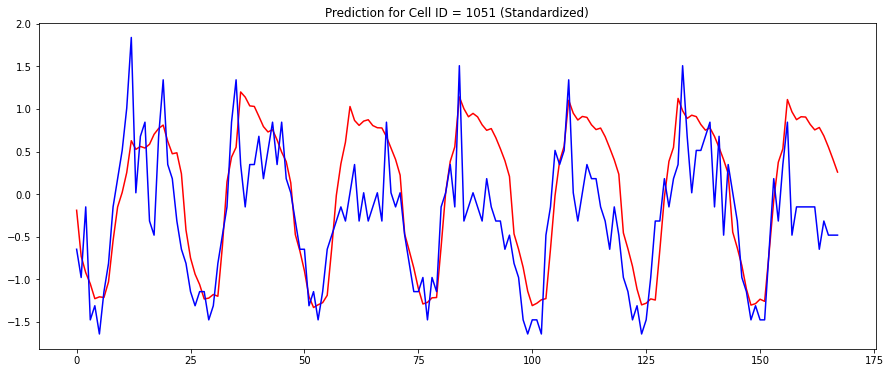

In [11]:
#---Plotting the predictions

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d (Standardized)' % (Cell_ID[60])) 
plt.plot(predictions_standardized,'r')
plt.plot(time_series_standardized[train_size+validation_size:],'b')

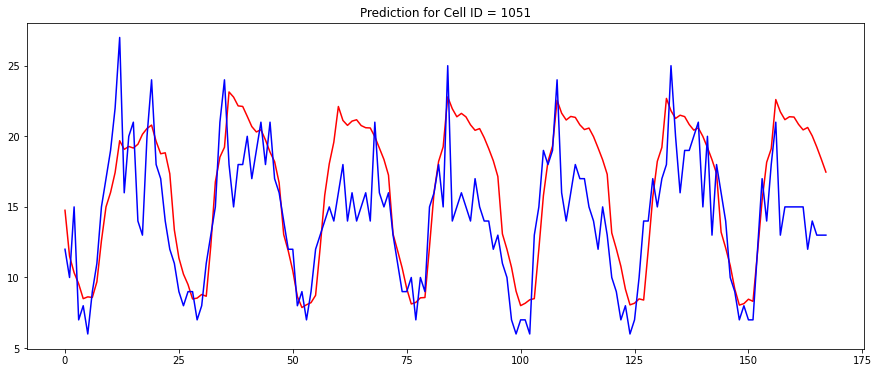

In [12]:
#--Ploting the actual result (not considering mean and std)
predictions_standardized = np.array(predictions_standardized)
predictions_week = predictions_standardized*time_series_std+time_series_mean

plt.figure(figsize=(15,6))
plt.title('Prediction for Cell ID = %d' % (Cell_ID[60])) 
plt.plot(predictions_week,'r')
plt.plot(y_test,'b')

In [13]:
MAE = mean_absolute_error(predictions_week,y_test)
MSE = mean_squared_error(predictions_week,y_test)
print('MAE:', "%.3f" % MAE)
print('MSE:', "%.3f" % MSE)

MAE: 3.074
MSE: 14.216
